# Image Processing with Python: Object Detection using Template Matching



### How can we detect and recognize objects in an image?

In this post, we will learn how we can find an object in an input image using template matching. This technique is particularly useful in image detection and recognition, as well as to object tracking.

Let’s begin.

As usual, we import libraries such as `numpy`and `matplotlib`. Additionally, we import specific functions from the `skimage` library.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread, imshow
from skimage.color import rgb2gray
from skimage.feature import match_template, peak_local_max
from skimage import transform

Let us define what **template matching** is. It is a technique for finding a reference image (or a template image) in the source image. In its most basic sense, the algorithm works by comparing the template for each part of the source image by sliding it one pixel at a time. This process is known as **cross-correlation**. This algorithm’s output is another image whose pixel value corresponds to the similarity of the template image to the source image when it was placed at that pixel location.

To explore how this works, let’s use an image of a condominium building. Let’s say that our object of interest is the windows in the building.

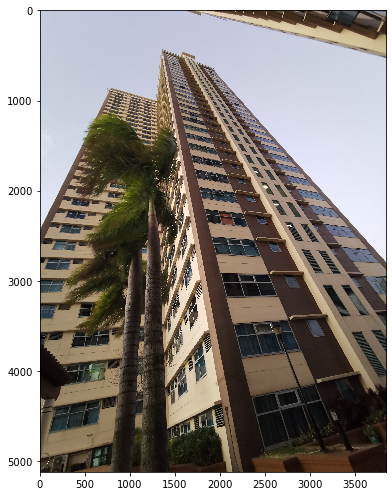

In [2]:
plt.figure(figsize=(7,7))

condo = imread('condo.jpg')
condo_gray = rgb2gray(condo)
imshow(condo);

Notice the repeating patterns of the windows on this building. Let’s try to use this algorithm to count the number of windows in this building!

To do this, I have created the `find_template` function that inputs the template’s coordinates to be used and will output the similarity of the template image and the input image.

In [3]:
def find_template(image, x, y, x_width, y_width):
    fig, ax = plt.subplots(1,2, figsize=(14,10))
    
    template = image[y:y+y_width, x:x+x_width]
    ax[0].imshow(template, cmap='gray')
    ax[0].set_title('Object Template')
    result = match_template(image, template)
    ax[1].imshow(result, cmap='viridis');
    ax[1].set_title('Cross-correlation image')
    
    coor_x, coor_y = np.unravel_index(np.argmax(result), result.shape)
    
    return coor_x, coor_y, template, result

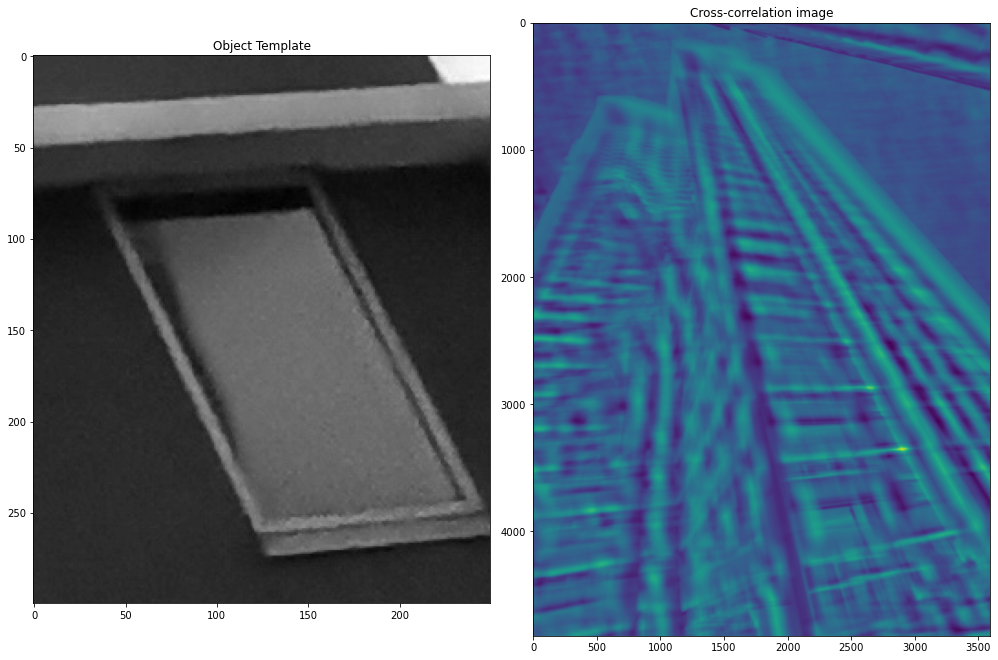

In [4]:
x, y, template, result = find_template(condo_gray, 
                                       x=2900, y=3350, 
                                       x_width=250, 
                                       y_width=300)
plt.tight_layout()

Notice how there are yellow spots on the resulting cross-correlation image. This signifies the regions in the input image where the template matches. Let’s try to reflect these regions on the actual image for a more straightforward analysis!

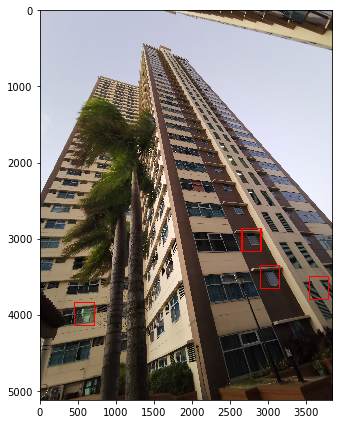

In [5]:
plt.figure(figsize=(6,6))

imshow(condo)
template_width, template_height = template.shape
for x, y in peak_local_max(result, threshold_abs=0.5):
    rect = plt.Rectangle((y, x), 
                         template_height, 
                         template_width, 
                         color='r', 
                         fc='none')
    plt.gca().add_patch(rect);

We can see that even though the windows are repeating on the building, the template matching algorithm failed to detect these objects. This can be attributed to the underlying limitations of the algorithm. These are:

1. It is **NOT scale-invariant**, which means that the size of the objects should be the same
2. It is **NOT rotational-invariant**, which means that the orientation of the objects should be the same
3. It is **NOT intensity-invariant**, which means the color shades (in grayscale) of the objects should be the same

So is this problem a lost case? Not necessarily! We can apply image processing techniques to solve this problem.

From my previous post, We can use the homography matrix to transform the image to be more manageable before running the template matching algorithm. I will no longer discuss how the homography matrix works. *If you haven’t read that post yet, I suggest you read it first to understand the image processing steps that will be done here.*

By defining the `area_of_interest` to be the edges of the building, we can warp the image to adjust the image’s perspective.

In [6]:
area_of_interest = [(1359, 460),
                    (1931, 670),
                    (3830, 2800),
                    (1790, 2700)]

area_of_projection = [(1500, 1000),
                      (2500, 1000),
                      (2500, 4500),
                      (1500, 4500)]

In [7]:
def project_planes(image, src, dst):
    x_src = [val[0] for val in src] + [src[0][0]]
    y_src = [val[1] for val in src] + [src[0][1]]

    x_dst = [val[0] for val in dst] + [dst[0][0]]
    y_dst = [val[1] for val in dst] + [dst[0][1]]
    
    fig, ax = plt.subplots(1,2, figsize=(13,8))
    
    new_image = image.copy() 
    projection = np.zeros_like(new_image)

    tform = transform.estimate_transform('projective', 
                                         np.array(src), 
                                         np.array(dst))
    transformed = transform.warp(image, tform.inverse)
    
    ax[0].imshow(new_image);
    ax[0].plot(x_src, y_src, 'r--')
    ax[0].set_title('Original Image')
    
    ax[1].imshow(transformed)
    ax[1].plot(x_dst, y_dst, 'r--')
    ax[1].set_title('Warped Image')
    plt.tight_layout()
    return transformed

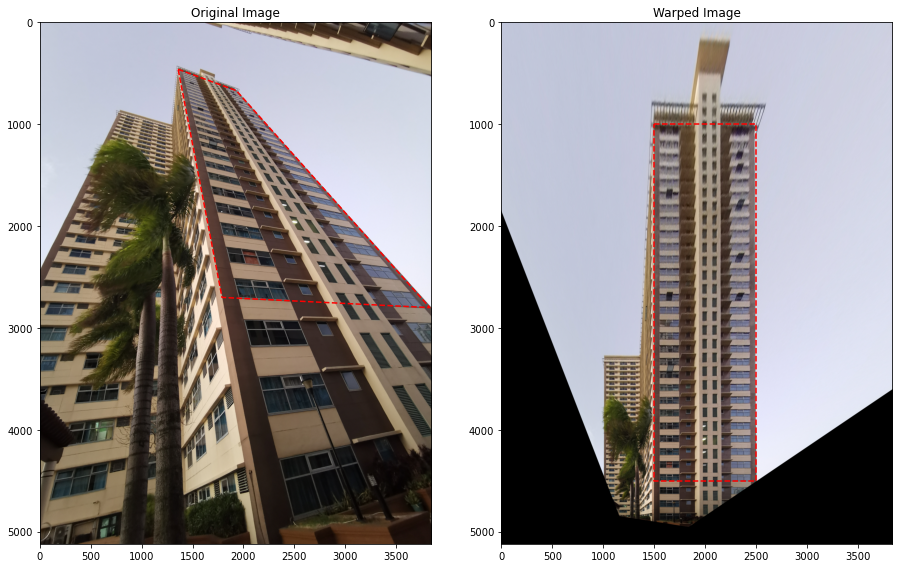

In [8]:
transformed = project_planes(condo, area_of_interest, area_of_projection)

Amazing, *right!?* Now that the building’s face is planar, let’s inspect if the limitations of the template matching algorithm are addressed.

First, the window size is now approximately the same. Second, the window orientation is all upright. Lastly, the color shades of windows of the same class are also the same. With this, we can now apply the template matching algorithm!

Let’s use the double window on the emergency staircase of the building as our object template.

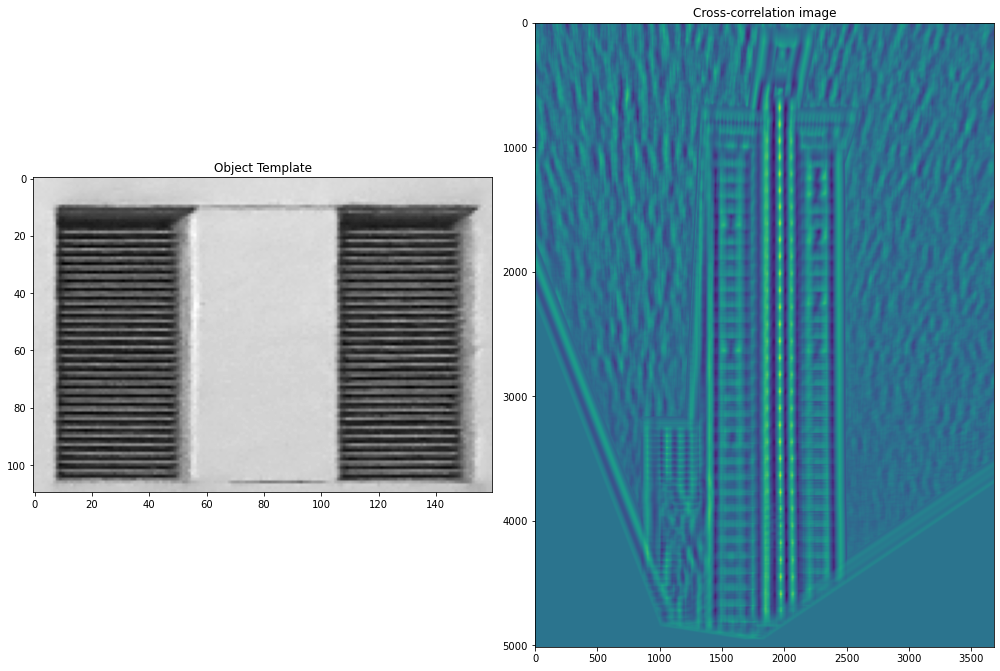

In [9]:
transformed_gray = rgb2gray(transformed)

x, y, template, result = find_template(transformed_gray, 
                                       x=1970, y=4450, 
                                       x_width=160, 
                                       y_width=110)
plt.tight_layout()

Notice that the yellow spots on the resulting cross-correlation image are much greater than when we did not use the homography matrix. This signifies the homography matrix is effective in addressing the limitations of the template matching algorithm! Let’s reflect these matches on the actual image.

In [10]:
def show_matches(image, template, result, x, y, threshold=1):
    plt.figure(figsize=(6,6))

    imshow(image)
    template_width, template_height = template.shape
    for x, y in peak_local_max(result, threshold_abs=threshold):
        rect = plt.Rectangle((y, x), 
                             template_height, 
                             template_width, 
                             color='r', 
                             fc='none')
        plt.gca().add_patch(rect);

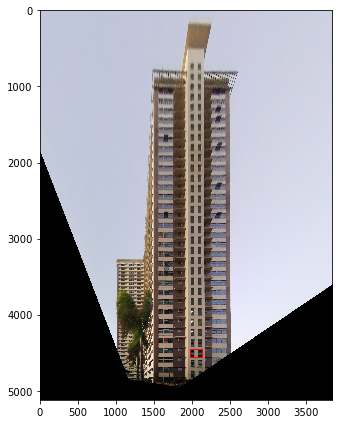

In [11]:
show_matches(transformed, template, result, x, y, threshold=1)

When the threshold is set to 1, only one object is detected — *and this is our template*. This signifies that the windows are not matching. However, based on the yellow spots on the cross-correlation image, more than one object is detected. From this, we can deduce that the objects are not exact matches of each other. To address this, we can reduce the threshold to detect more windows of the same structure.

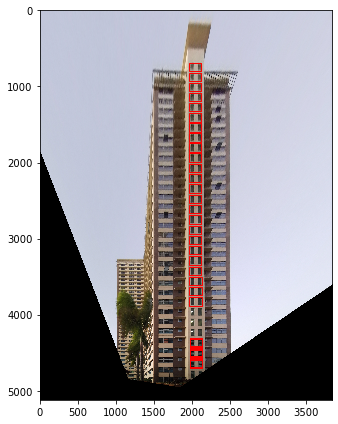

In [12]:
show_matches(transformed, template, result, x, y, threshold=0.8)

By setting the threshold to 0.80, we have successfully detected most of the windows of a similar structure as the template image. We can see the turned on lights at the windows that were not detected. Remember that one of the limitations of the template matching algorithm is it is not intensity invariant? This is the reason why the algorithm does not detect these objects. Moreover, we should also take note that the *threshold should not be too low* because it can cause the detection of ghost objects.

Now, let’s try other objects in the image. We can use the opened windows as our template in this next example.

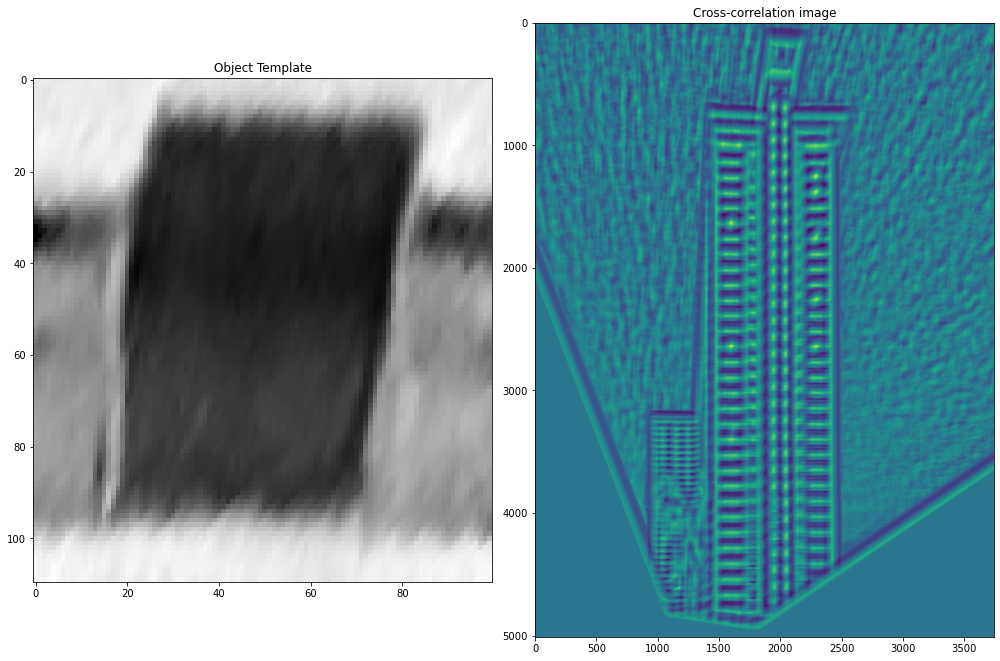

In [13]:
x, y, template, result = find_template(transformed_gray, 
                                       x=1600, y=2640, 
                                       x_width=100, 
                                       y_width=110)
plt.tight_layout()

Again, notice how there are yellow spots on the cross-correlation matrix? This signifies that it has detected matches between the object template and the resulting image. Let’s take a look!

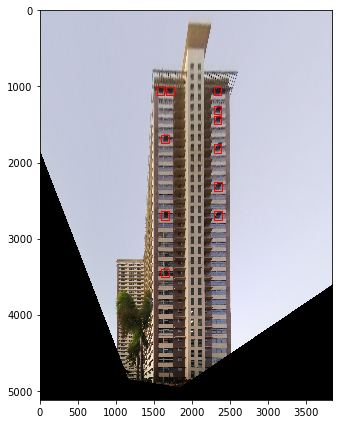

In [14]:
show_matches(transformed, template, result, x, y, 0.7)

From this image, it is clear that the algorithm could detect all of the opened windows from the condominium building. Amazing, right?

#### In summary

We have explored how to use the template matching algorithm to detect objects from our image. We have also explored how the homography matrix can help address the template matching algorithm’s limitations by warping the image to achieve similar scales and orientations for the objects.

I hope you were able to appreciate the potential of the template matching algorithm. However, note that template matching is one of the most basic algorithms for object detection. Other algorithms have already addressed the limitations of the template matching algorithm, but I’m going to leave it for you to research!
